In [1]:
import numpy as np
import h5py
import json

from keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


### 载入数据集

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

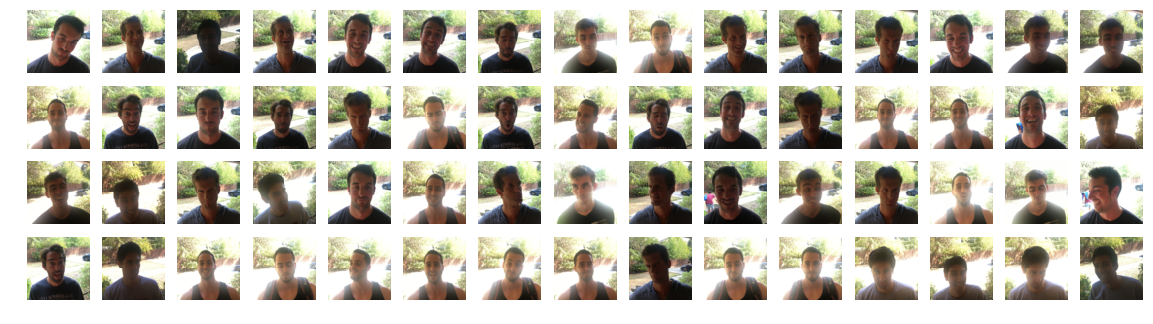

In [4]:
# 绘制训练样本图片集 前60张
X_orig = X_train_orig[:60]
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

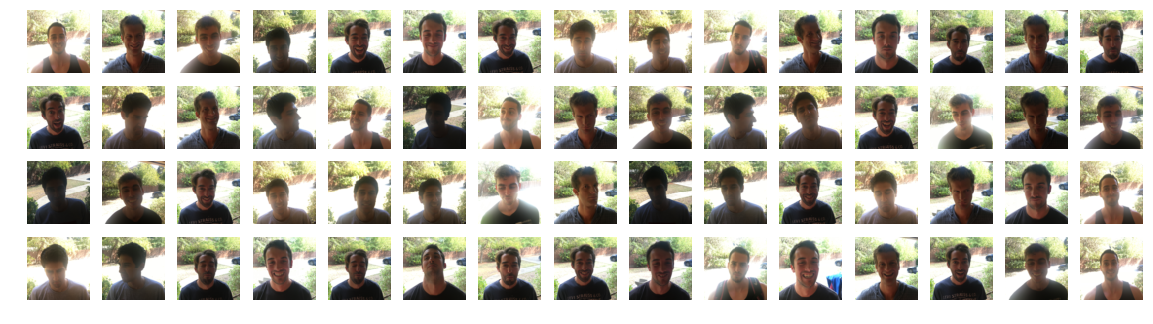

In [5]:
# 绘制测试样本图片集 前60张
X_orig = X_test_orig[:60]
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

### 标准化输入

In [6]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


### 载入预训练VGG16模型

In [7]:
# 主流CNN模型
# Xception
# InceptionV3
# InceptionResNetV2
# VGG16
# VGG19
# ResNet50
# MobileNetV2

In [8]:
from keras.applications.vgg16 import VGG16

# VGG16模型,权重由ImageNet训练而来
base_model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

In [9]:
base_model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

### 迁移学习

In [10]:
X = base_model_vgg16.output
X = Flatten()(X)
# add a fully-connected layer
X = Dense(64, activation='relu')(X)
# and a logistic layer
predictions = Dense(1, activation='sigmoid')(X)

In [11]:
# this is the model we will train
model = Model(inputs=base_model_vgg16.input, outputs=predictions)

In [12]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_vgg16.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [13]:
# we chose to train the top 1 block, i.e. we will freeze the first 15 layers:
for layer in model.layers[:15]:
   layer.trainable = False

In [14]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

### 训练模型

In [16]:
# train the model on the new data for a few epochs
history = model.fit(x=X_train, y=Y_train, batch_size=16, epochs=15, validation_split=0.1)

Train on 540 samples, validate on 60 samples
Epoch 1/15
540/540 [==============================] - 25s 47ms/step - loss: 1.4674 - acc: 0.5389 - val_loss: 0.9203 - val_acc: 0.4833
Epoch 2/15
540/540 [==============================] - 25s 47ms/step - loss: 0.5308 - acc: 0.7296 - val_loss: 0.4885 - val_acc: 0.6500
Epoch 3/15
540/540 [==============================] - 25s 46ms/step - loss: 0.3076 - acc: 0.8685 - val_loss: 0.1591 - val_acc: 0.9833
Epoch 4/15
540/540 [==============================] - 25s 46ms/step - loss: 0.1597 - acc: 0.9407 - val_loss: 0.1343 - val_acc: 0.9167
Epoch 5/15
540/540 [==============================] - 25s 46ms/step - loss: 0.1300 - acc: 0.9481 - val_loss: 0.1897 - val_acc: 0.9000
Epoch 6/15
540/540 [==============================] - 25s 46ms/step - loss: 0.0821 - acc: 0.9759 - val_loss: 0.1341 - val_acc: 0.9500
Epoch 7/15
540/540 [==============================] - 25s 46ms/step - loss: 0.0699 - acc: 0.9815 - val_loss: 0.2072 - val_acc: 0.9167
Epoch 8/15
540/54

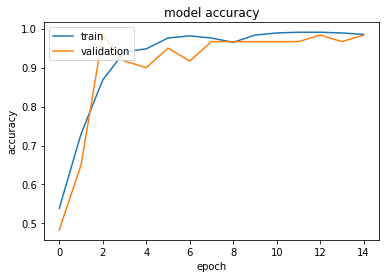

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

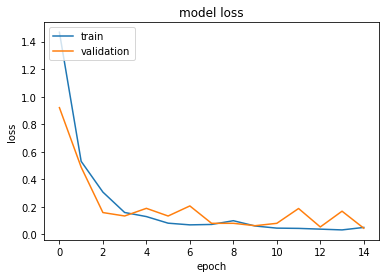

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 评估模型

In [19]:
preds = model.evaluate(x=X_test, y=Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 4s 26ms/step
Loss = 0.05314345146218936
Test Accuracy = 0.9799999976158142
